**Stack Exchange - Data Scraping for Questions and Tags**

We want to scrape the distributions of numbers of Questions & Tags for the webpage [Stack Echange - ask ubuntu](https://askubuntu.com/) to see if we find anything interesting. To do this, we’ll first scrape data related to Questions and Tags from Stack Exchange webpage for all the respective pages.


**Working out which pages to scrape**

  Once we've defined our goal, we then need to identify an efficient set of pages to scrape. In order to scrape data from the respective web pages, we use the `request` library. A request is what happens when we access a web page. We 'request' the content of a page from the server.

In [1]:
# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from requests import get
import warnings
warnings.filterwarnings("ignore")
from requests import get
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.util import *
from nltk.corpus import stopwords
import re
import seaborn as sns
from collections import defaultdict

In [2]:
url = 'https://askubuntu.com/questions'
time.sleep(5)
# Getting the response from the source URL.
response = get(url)
print(response.text[:500])

<!DOCTYPE html>


    <html class="html__responsive">

    <head>

        <title>Newest Questions - Ask Ubuntu</title>
        <link rel="shortcut icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/favicon.ico?v=928dfb7c1990">
        <link rel="apple-touch-icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6">
        <link rel="image_src" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6"> 
        <lin


As we can see from the first line of response.text, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

In [3]:
# Parsing respose.txt by creating a BeautifulSoup object and assigning it to htlm_soup.
time.sleep(5)
html_soup = BeautifulSoup(response.text, 'html.parser')


In [4]:
# Printing the total questions summary for each page (pagination set to 50 for viewing purpose)
# The div tag has a class named question-summary that displays to us the entire information for a question posted.

Questions_EachPage = html_soup.find_all('div', class_ = 'question-summary')
print(type(Questions_EachPage))
print(len(Questions_EachPage))

<class 'bs4.element.ResultSet'>
50


As we can see the question summary class count comes out to be 50, which is what we had expected depending on the pagination that we have set.

However, we are only interested to scrape the Questions from this summary and not other things like time, comments, votes, answers,views etc. So, we will only deal with the tag `<h3>` and `<a>`.

**Extracting data for a single question:**


In [5]:
# Printing out the HTLM content of our first question.

first_question = Questions_EachPage[0]
print(first_question)

<div class="question-summary" id="question-summary-1288750">
<div class="statscontainer">
<div class="stats">
<div class="vote">
<div class="votes">
<span class="vote-count-post"><strong>0</strong></span>
<div class="viewcount">votes</div>
</div>
</div>
<div class="status unanswered">
<strong>0</strong>answers
            </div>
</div>
<div class="views" title="2 views">
    2 views
</div>
</div>
<div class="summary">
<h3><a class="question-hyperlink" href="/questions/1288750/how-create-a-bootable-rescue-partition-on-a-remote-machine-to-ssh-in-case-of-boo">How create a bootable rescue partition on a remote machine to ssh in case of boot error?</a></h3>
<div class="excerpt">
            Basically is it possible at all and if it is, how to do it. I need to access a remote machine in case of boot errors to fix them using for example fsck when all partitions should be unmounted etc.
        </div>
<div class="tags t-boot">
<a class="post-tag" href="/questions/tagged/boot" rel="tag" title="

As we can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

In [6]:
# Hitting the webpage to validate if there are any timeouts or connection reset warnings using try except()

from urllib.request import urlopen 
from socket import timeout

url = "https://askubuntu.com/questions?tab=newest&pagesize=50"
try: 
    string = urlopen(url, timeout=5).read()
except ConnectionResetError:
    print("==> ConnectionResetError")
    pass
except timeout: 
    print("==> Timeout")
    pass

In [7]:
pages_list=[]                         # Empty list that will be appended with the page count

pages_list.append("https://askubuntu.com/questions?tab=newest&pagesize=50")

for page in list(range(2, 601)):     # Looping over first 400 webpages

  pages_list.append('https://askubuntu.com/questions?tab=newest&page='+str(page))
  
print(len(pages_list))

600


In [8]:
questions_list=[]                     # Creating an empty list of questions that will be appended with the question counts.

# time.sleep(5)
for x in pages_list:                  # Looping over all the pages in the page list
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  question_name = soup.find_all('h3')   # Finding the h3 tag that has details of the question
  for question in question_name:
        if question.find('a'):
            questions_list.append(question.find('a').text)

In [9]:
# Printing the length of the questions scraped and the top 10 questions.

print(len(questions_list))
print(questions_list[:11])

31200
['current community', 'more stack exchange communities', 'How create a bootable rescue partition on a remote machine to ssh in case of boot error?', 'Dell Latitude E6410/ ubuntu 20.04/ Airplane mode switch on automatically', 'Pop OS 20.04 not running gpu driver [closed]', 'Searching shortcut for selecting multiple files in Nautilus', 'Message of the day exited with return code 2', 'how to update languages manually', 'Intel RST isssue while installing Ubuntu 20.04 LTS as Dual boot', 'cannot pair microbit through usb on Xubuntu 16', 'Rhythmbox get List of Played Songs']


In [10]:
# To get the tags from the webpage

def ListToString(string):
  # initialize an empty string 
  string1 = ""
    
  # traverse in the string   
  for element in string:  
      string1 = string1 + element   
     
  return string1


tag=[]

for x in pages_list:
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  tags=[]

  for div in soup.find_all('div', {"class": re.compile("^tags")}):      
    tags.append(div.get('class')[1:])



  clean_tags=[]

  for i in tags:
    clean_tags.append(ListToString(i).replace('t-','|'))



  for j in clean_tags:
    tag.append(j[1:])

In [61]:
print(len(tag))
print(tag[:11])

30000
['networking|18û04|server', 'boot', '16û04|20û04|dell|airplane-mode', 'drivers|nvidia|graphics|xorg', 'nautilus|filemanager', 'login|motd', 'kubuntu|language-support', 'dual-boot|20û04|windows|rst', 'usb|xubuntu', '20û04|music|rhythmbox|log|plugins', 'wine|playonlinux']


In [62]:
# Creating a dataframe for questions and tags

ask_ubuntu_df = pd.DataFrame(list(zip(tag, questions_list)), columns =['Tags', 'Questions']) 
ask_ubuntu_df.head(10)

,Tags,Questions
0,networking|18û04|server,current community
1,boot,more stack exchange communities
2,16û04|20û04|dell|airplane-mode,How create a bootable rescue partition on a re...
3,drivers|nvidia|graphics|xorg,Dell Latitude E6410/ ubuntu 20.04/ Airplane mo...
4,nautilus|filemanager,Pop OS 20.04 not running gpu driver [closed]
5,login|motd,Searching shortcut for selecting multiple file...
6,kubuntu|language-support,Message of the day exited with return code 2
7,dual-boot|20û04|windows|rst,how to update languages manually
8,usb|xubuntu,Intel RST isssue while installing Ubuntu 20.04...
9,20û04|music|rhythmbox|log|plugins,cannot pair microbit through usb on Xubuntu 16


In [63]:
# Creating a func() called build_ngrams to analyse data in the form of unigrams, bigrams, ngrams etc.

def build_ngrams(ask_ubuntu_text, ngram):
    ask_ubuntu_text = ask_ubuntu_text.lower()
    ask_ubuntu_text = remove_space.sub(' ', ask_ubuntu_text)
    ask_ubuntu_text = bad_symbols.sub(' ', ask_ubuntu_text)
    ask_ubuntu_text = ' '.join(word for word in ask_ubuntu_text.split() if word not in STOPWORDS) 
    tokenize = nltk.word_tokenize(ask_ubuntu_text)
    return list(ngrams(tokenize, ngram))

In [64]:
# Handling spaces in text and bad symbols and eliminating those using regex.

remove_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [68]:
# Looping over questions list and building unigrams from the list.

onegram_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 1):
        onegram_tags_freq[word] = onegram_tags_freq[word] + 1

In [69]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(20, 15))
    freq = pd.DataFrame(sorted(data.items(), key=lambda x: x[1]), columns=['Words','Count'])
    sns.barplot(x='Count', y='Words', data=freq.sort_values(by="Count", ascending=True).tail(30))
    plt.title(title)
    plt.tight_layout()
    plt.show()

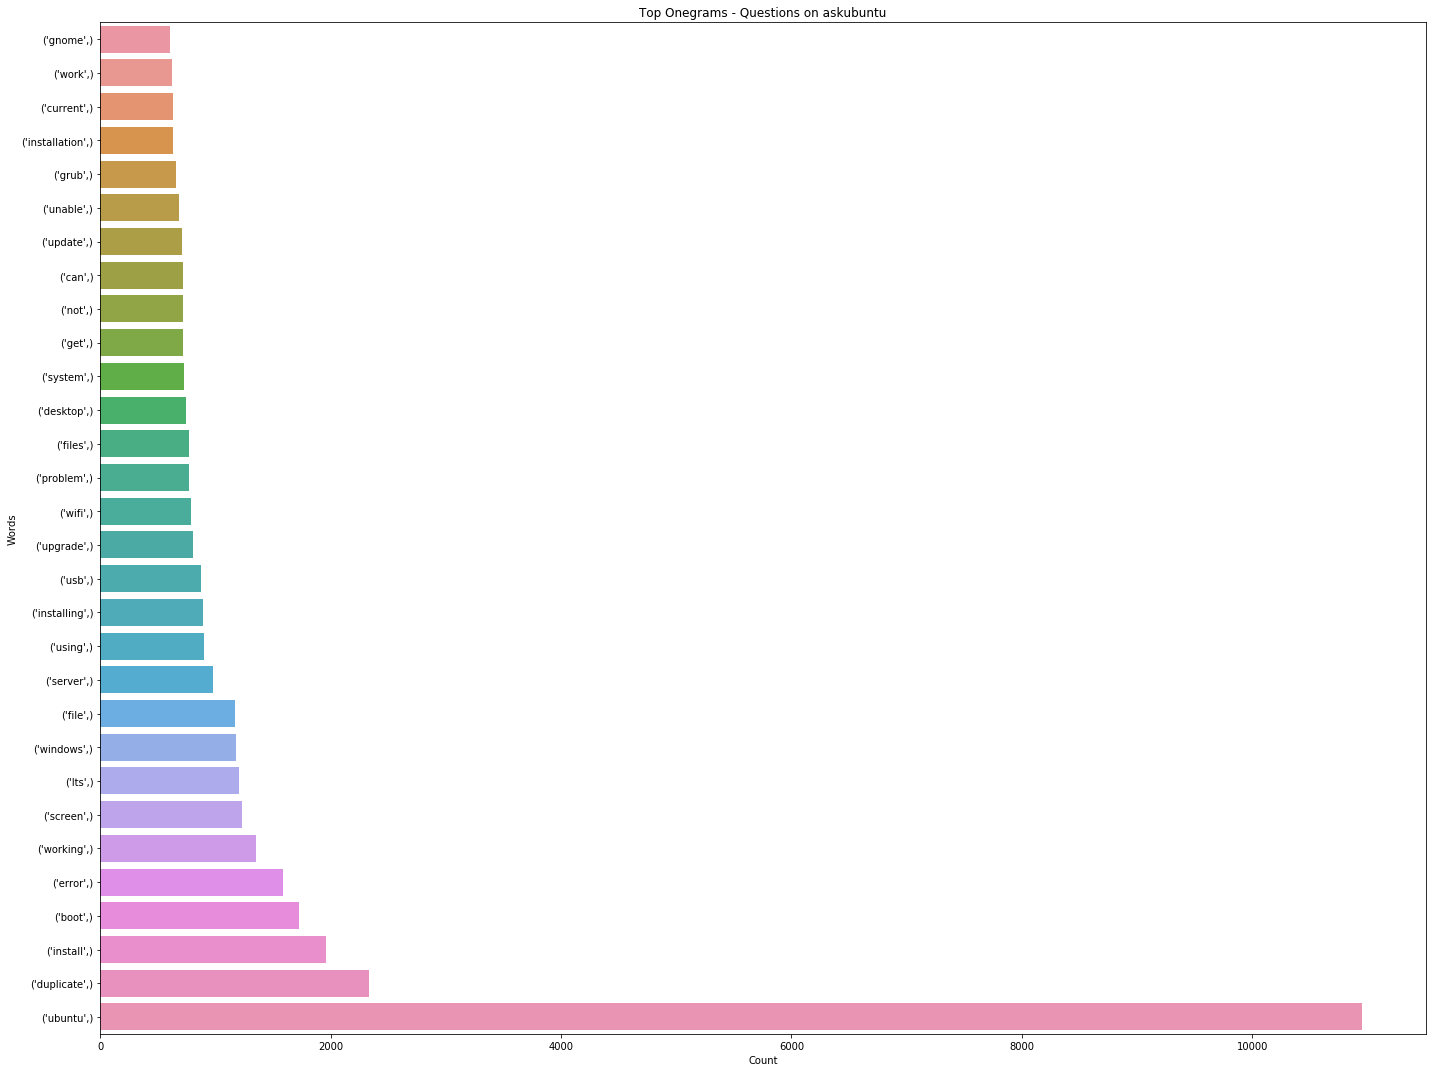

In [70]:
plot_horizontal_bar(onegram_tags_freq, 'Top Onegrams - Questions on askubuntu')

In [71]:
# Looping over questions list and building bigrams from the list.

bigrams_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 2):
        bigrams_tags_freq[word] = bigrams_tags_freq[word] + 1

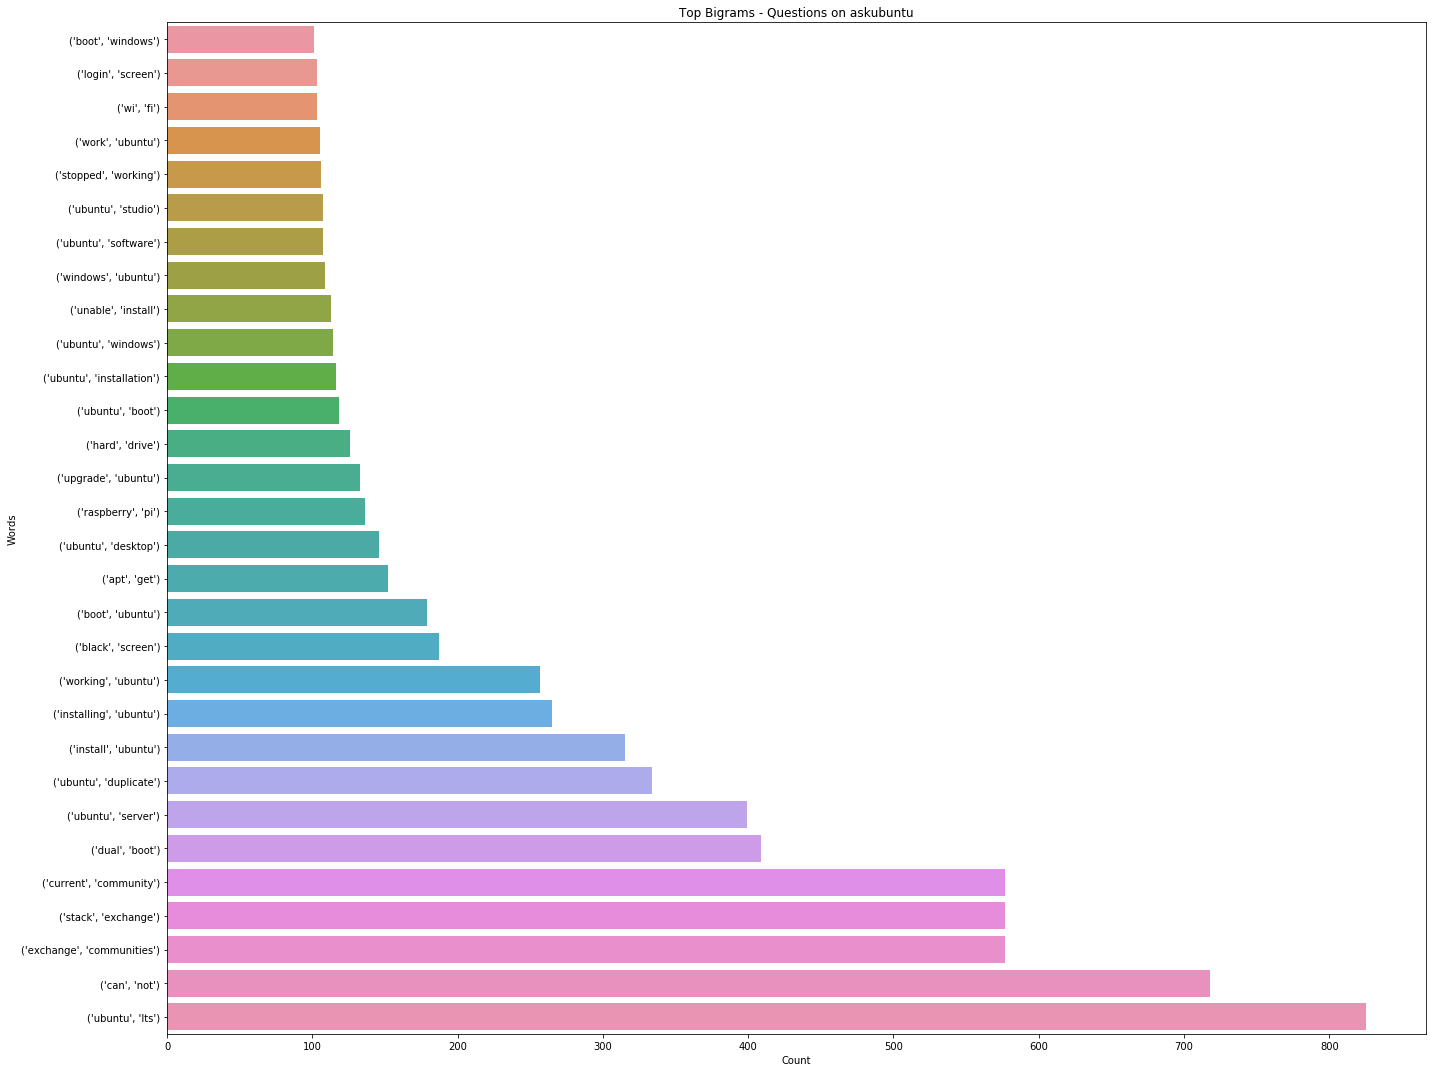

In [72]:
plot_horizontal_bar(bigrams_tags_freq, 'Top Bigrams - Questions on askubuntu')

In [73]:
# Looping over questions list and building bigrams from the list.

trigrams_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 3):
        trigrams_tags_freq[word] = trigrams_tags_freq[word] + 1

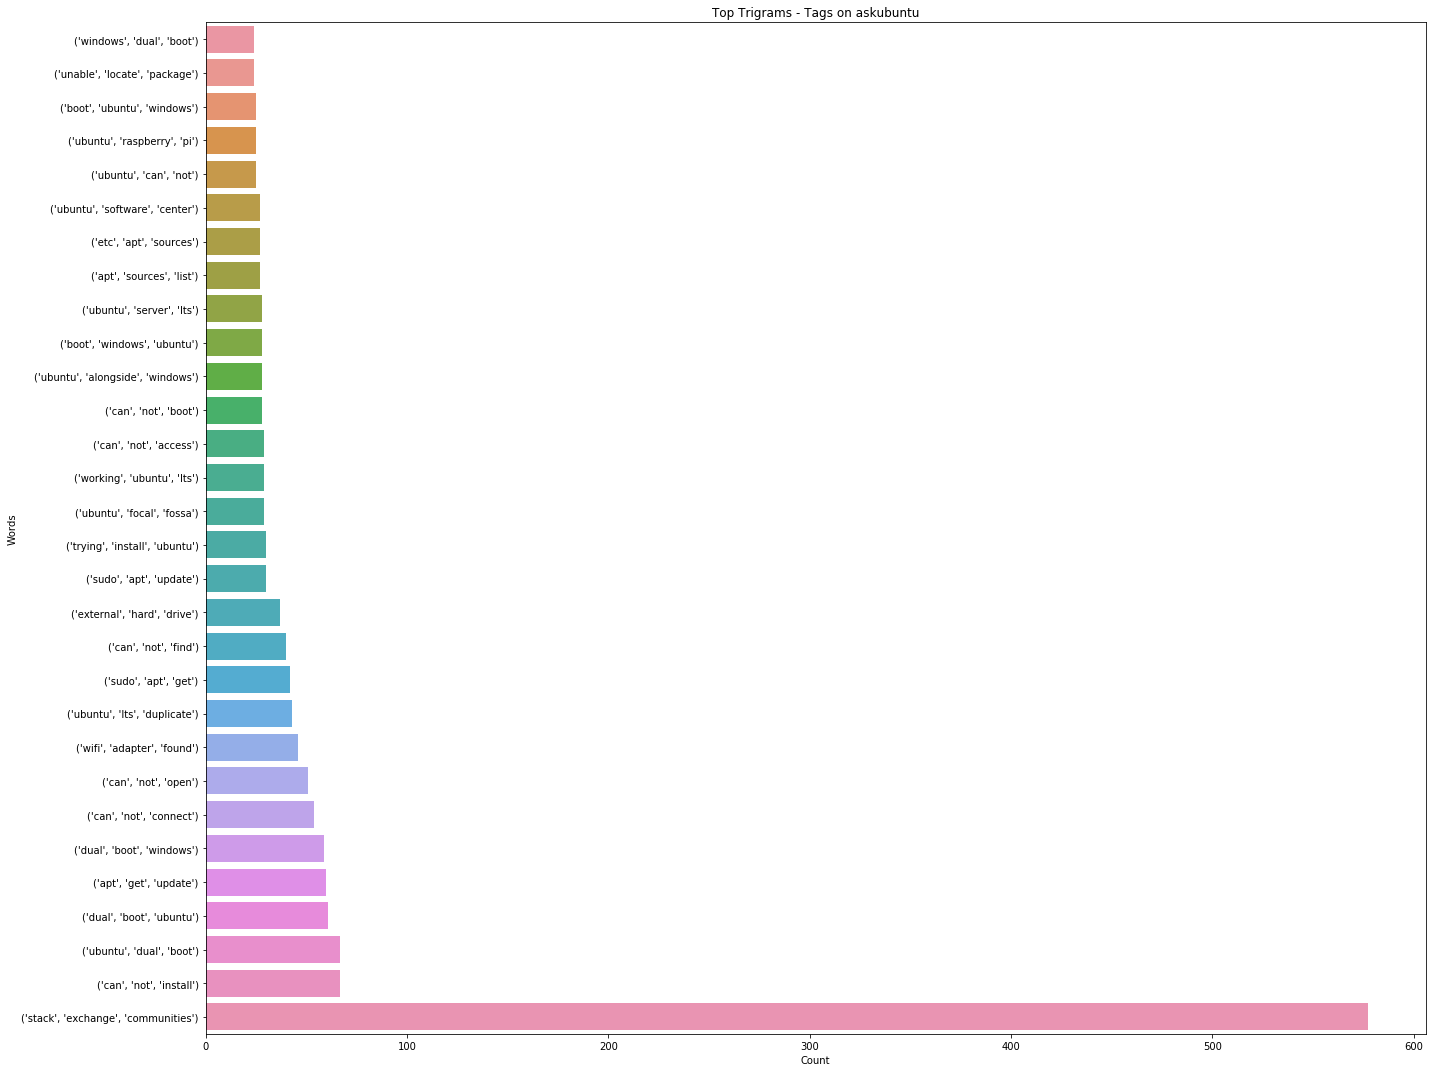

In [74]:
plot_horizontal_bar(trigrams_tags_freq, 'Top Trigrams - Tags on askubuntu')

In [22]:
# Removing special characters, hyperlinks/URL's from the Questions and Tags.

ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace('()','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace(';','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace(':','')
ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace('/','')


ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('()','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace(';','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace(':','')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('û','.')
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('\t','')

In [23]:
# Joining all the tags and storing those in a variable for plotting in a wordcloud
ask_ubuntu_tags = ' '.join(ask_ubuntu_df['Tags'].str.lower())

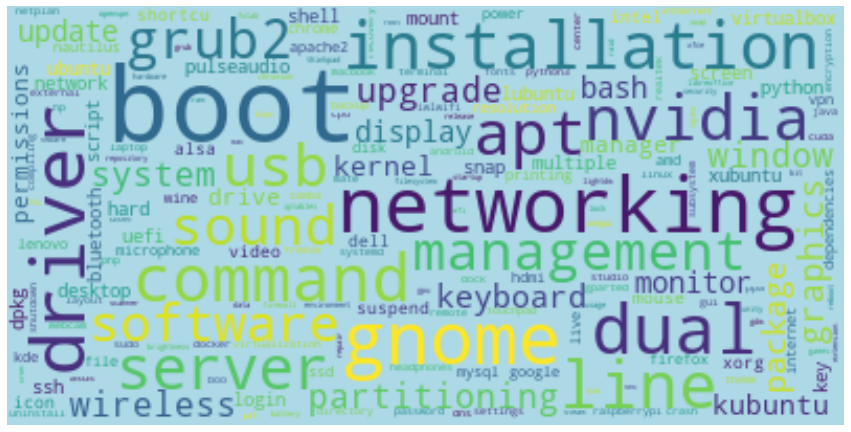

In [24]:
wordcloud = WordCloud(max_font_size=50, collocations=False, background_color='lightblue').generate(ask_ubuntu_tags)
plt.figure(figsize=(15,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
ask_ubuntu_df["Tags"] = [item.replace("|", " __label__") for item in ask_ubuntu_df["Tags"]]
ask_ubuntu_df['Tags'] ='__label__' + ask_ubuntu_df['Tags'].astype(str)
ask_ubuntu_df.head()

,Tags,Questions
0,__label__networking __label__18.04 __label__se...,current community
1,__label__boot,more stack exchange communities
2,__label__16.04 __label__20.04 __label__dell __...,How create a bootable rescue partition on a re...
3,__label__drivers __label__nvidia __label__grap...,Dell Latitude E6410 ubuntu 20.04 Airplane mode...
4,__label__nautilus __label__filemanager,Pop OS 20.04 not running gpu driver [closed]


In [26]:
# Setting the current working directory

relative_path = "/Users/Agam/Project Files/"
os.chdir(relative_path)

In [27]:
# Cloning and Installing fastText
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.
/Users/Agam/Project Files/fastText
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=nativ

In [28]:
# Changing the respective path to the fastText directory after cloning fastText.

relative_path = "/Users/Agam/Project Files/fastText"
os.chdir(relative_path)

In [29]:
# Save the DataFrame as a .txt file which is required for feeding to fastText

np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.txt', ask_ubuntu_df.values, fmt='%s', delimiter='\t')

In [30]:
!head "/Users/Agam/Project Files/fastText/ask_ubuntu.txt"

__label__networking __label__18.04 __label__server	current community
__label__boot	more stack exchange communities
__label__16.04 __label__20.04 __label__dell __label__airplane-mode	How create a bootable rescue partition on a remote machine to ssh in case of boot error?
__label__drivers __label__nvidia __label__graphics __label__xorg	Dell Latitude E6410 ubuntu 20.04 Airplane mode switch on automatically
__label__nautilus __label__filemanager	Pop OS 20.04 not running gpu driver [closed]
__label__login __label__motd	Searching shortcut for selecting multiple files in Nautilus
__label__kubuntu __label__language-support	Message of the day exited with return code 2
__label__dual-boot __label__20.04 __label__windows __label__rst	how to update languages manually
__label__usb __label__xubuntu	Intel RST isssue while installing Ubuntu 20.04 LTS as Dual boot
__label__20.04 __label__music __label__rhythmbox __label__log __label__plugins	cannot pair microbit through usb on Xubuntu 16


In [31]:
# Splitting the data into training, validation and testing.

train_data= round(len(ask_ubuntu_df)*0.70)
validation_data = round(len(ask_ubuntu_df)*0.15)
testing_data = round(len(ask_ubuntu_df)*0.15) 

print("Number of records for training dataset are:", train_data)
print("Number of records for validation dataset are:", validation_data)
print("Number of records for testing dataset are:", testing_data)

Number of records for training dataset are: 21000
Number of records for validation dataset are: 4500
Number of records for testing dataset are: 4500


In [32]:
ask_ubuntu_df.head(10)

,Tags,Questions
0,__label__networking __label__18.04 __label__se...,current community
1,__label__boot,more stack exchange communities
2,__label__16.04 __label__20.04 __label__dell __...,How create a bootable rescue partition on a re...
3,__label__drivers __label__nvidia __label__grap...,Dell Latitude E6410 ubuntu 20.04 Airplane mode...
4,__label__nautilus __label__filemanager,Pop OS 20.04 not running gpu driver [closed]
5,__label__login __label__motd,Searching shortcut for selecting multiple file...
6,__label__kubuntu __label__language-support,Message of the day exited with return code 2
7,__label__dual-boot __label__20.04 __label__win...,how to update languages manually
8,__label__usb __label__xubuntu,Intel RST isssue while installing Ubuntu 20.04...
9,__label__20.04 __label__music __label__rhythmb...,cannot pair microbit through usb on Xubuntu 16


In [33]:
training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt", 
                           nrows=train_data,header=None,error_bad_lines=False,sep='\t')
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt",
                          skiprows=train_data,nrows=validation_data,
                          header=None,error_bad_lines=False,sep='\t')
test_data = pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt",
                          skiprows=(train_data+validation_data),
                          nrows=testing_data,header=None,error_bad_lines=False,sep='\t')

b'Skipping line 29282: expected 2 fields, saw 3\n'


In [34]:
# Saving the training and validation files.

np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.test', test_data.values, fmt='%s', delimiter='\t')

In [35]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_unprocessed

Read 0M words
Number of words:  23145
Number of labels: 2123
Progress: 100.0% words/sec/thread:    6262 lr:  0.000000 avg.loss: 10.321381 ETA:   0h 0m 0s  0h 0m15s0.075924 avg.loss: 11.821156 ETA:   0h 0m14s ETA:   0h 0m11s9s


In [36]:
# Validating model accuracy on the validation set.

Score_1 = !./fasttext test ./model_unprocessed.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_1

['N\t4494', 'P@1\t0.279', 'R@1\t0.0917']

**As we can see that when the passed the train data to the fastText Model without pre-processing, the model gave a precision of 28%**

In [37]:
cat "/Users/Agam/Project Files/fastText/ask_ubuntu.txt" | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt"


Now we are cleaning pre-processing the data a bit by using the sed command and applying fasttext on the default model without any tuning any hyper parameters.

In [38]:
training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt", 
                           nrows=train_data,header=None,error_bad_lines=False,sep='\t')
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt",
                          skiprows=train_data,nrows=validation_data,
                          header=None,error_bad_lines=False,sep='\t')
test_data = pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt",
                          skiprows=(train_data+validation_data),
                          nrows=testing_data,header=None,error_bad_lines=False,sep='\t')

b'Skipping line 29282: expected 2 fields, saw 3\n'


In [39]:
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.test', test_data.values, fmt='%s', delimiter='\t')

Storing and saving the cleaned data files in the desired path.

In [40]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_preprocessed

Read 0M words
Number of words:  14781
Number of labels: 2110
Progress: 100.0% words/sec/thread:    7041 lr:  0.000000 avg.loss: 10.124292 ETA:   0h 0m 0s0m 0s


In [41]:
Score_2 = !./fasttext test ./model_preprocessed.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_2

['N\t4494', 'P@1\t0.314', 'R@1\t0.103']

As we can see from the model output, that pre-processing the data led to increase in precision (around 4%). Now, we can tune in and apply hyper parameters to have a look how the model precision improves in the process.

**Model run along with 25 epochs, wordNgrams and loss function as softmax and some other input parameters.**

In [42]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_preprocessed_param -lr 0.15 -epoch 25 -wordNgrams 3 -bucket 200000 -dim 50 -loss softmax -thread 160 -ws 5

Read 0M words
Number of words:  14781
Number of labels: 2110
Progress: 100.0% words/sec/thread:    1088 lr:  0.000000 avg.loss: 10.155656 ETA:   0h 0m 0s


In [43]:
Score_3 = !./fasttext test ./model_preprocessed_param.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_3

['N\t4494', 'P@1\t0.318', 'R@1\t0.105']

*As we can see from the model output, that the precision did not increase much after applying input parameters to the fastText Model with only a minor change of around 1%*.

**Looking at our predictions now, with argument -1 and getting the lables whose probability of occurence is less or equal to 0.1 only**

In [50]:
Score_4 = !./fasttext test ./model_preprocessed_param.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val" -1 0.1
Score_4

['N\t4494', 'P@-1\t0.639', 'R@-1\t0.0952']

**Looking at our predictions now, with argument -1 and getting the lables whose probability of occurence is less or equal to 0.5 only**

In [51]:
Score_5 = !./fasttext test ./model_preprocessed_param.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val" -1 0.5
Score_5

['N\t4494', 'P@-1\t0.79', 'R@-1\t0.00358']

*We are creating a datframe of the results which contains the type of model fitted and the Precision and Recall achieved with that Model fit*.

In [75]:
Results = {"Model Type" : ['Model_Unprocessed','Model_PreProcessed','Model_HyperParameters','Model_ProbOccurence: 0.1',
                        'Model_ProbOccurence: 0.5'],
        "Precision": [Score_1[1],Score_2[1], Score_3[1],Score_4[1],Score_5[1]],
        "Recall":[Score_1[2], Score_2[2],Score_3[2],Score_4[2],Score_5[2]]}

Results_df = pd.DataFrame(Results)

Results_df["Precision"] = Results_df["Precision"].str.replace("P@1", "").str.replace("\t","").str.replace("P@-1","")
Results_df["Recall"] = Results_df["Recall"].str.replace("R@1", "").str.replace("\t","").str.replace("R@-1","")

Results_df

,Model Type,Precision,Recall
0,Model_Unprocessed,0.279,0.0917
1,Model_PreProcessed,0.314,0.103
2,Model_HyperParameters,0.318,0.105
3,Model_ProbOccurence: 0.1,0.639,0.0952
4,Model_ProbOccurence: 0.5,0.79,0.00358
